In [2]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from simpegEM1D import skytem_HM_2015
time = np.logspace(-5, -2, 31)
# three layers
hz = np.array([10, 10, 10])
sigma_half = 0.1

# half-space conductivity
sigma = np.ones(hz.size) * sigma_half
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
# offset b/w VMD source and Bz receiver
offset = np.array([10.])

LocSigZ = -mesh1D.gridCC
TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.]),
    src_location = np.array([0., 0., 100.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'Bz',
    wave_type = 'stepoff',
    src_type = 'VMD',
    offset=offset,
    time = time,
)
imap = Maps.IdentityMap(mesh1D)
prob = EM1D(mesh1D, sigmaMap=imap, verbose=False)
prob.pair(TDsurvey)
bz = TDsurvey.dpred(sigma)

In [4]:
from simpegEM1D import EM1DAnalytics
from simpegEM1D.DigFilter import setFrequency, transFilt
from scipy.constants import mu_0
def bz_analytic_solution(r, t, sigma):
    """
    r: offset bewteen VMD soure and Bz receiver (m)
    t: measured times
    sigma: conductivity of the half-space earth
    """
    wt, tbase, omega_int = setFrequency(t)
    hz = EM1DAnalytics.Hzanal(sigma, omega_int/2/np.pi, r, 'secondary')
    # Treatment for inaccuracy in analytic solutions
    ind = omega_int < 0.2
    hz[ind] = 0.
    hzTD, f0 = transFilt(hz, wt, tbase, omega_int, t)
    return hzTD*mu_0

In [5]:
bz_analytic = bz_analytic_solution(offset, time, sigma_half)

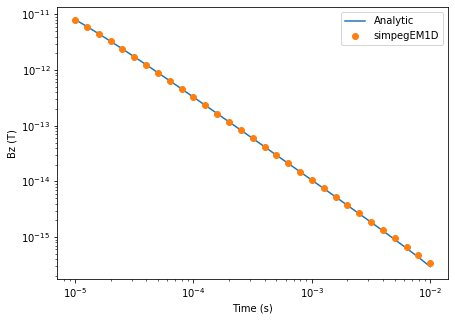

In [6]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, bz_analytic, '-')
axes.plot(TDsurvey.time, bz, 'o')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Bz (T)')
axes.legend(("Analytic", "simpegEM1D"))

In [3]:
import numpy as np
400 * np.sqrt(3) * 2

1385.6406460551018

In [6]:
from PVGeo.gslib import SGeMSGridReader
from pyvista import examples

In [11]:
from PVGeo.gslib import WriteImageDataToSGeMS

In [13]:
WriteImageDataToSGeMS??

In [7]:
filename, _ = examples.downloads._download_file('A_WLreferenceCAT.sgems')


In [16]:
filename

'C:\\Users\\sgkan\\AppData\\Local\\pyvista\\pyvista\\examples\\A_WLreferenceCAT.sgems'

In [17]:
grid = SGeMSGridReader().apply(filename)
print(grid)

UniformGrid (0x1fdb421aac8)
  N Cells:	78000
  N Points:	157122
  X Bounds:	0.000e+00, 2.600e+02
  Y Bounds:	0.000e+00, 3.000e+02
  Z Bounds:	0.000e+00, 1.000e+00
  Dimensions:	261, 301, 2
  Spacing:	1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:	1



In [19]:
grid?

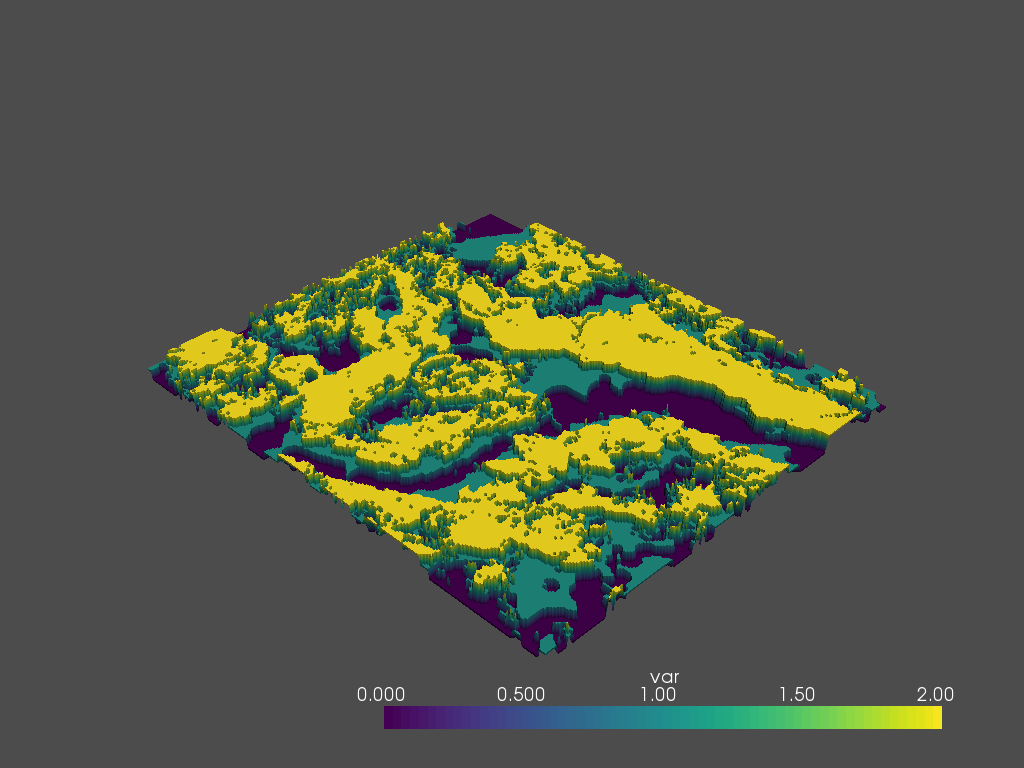

In [15]:
warped = grid.cell_data_to_point_data().warp_by_scalar(scale_factor=5)
warped.plot()